In [3]:
import json
from bedrock_text import BedrockText
from bedrock_image import BedrockAmazonImage, NovaImageSize, ImageParams, ControlMode
from bedrock_model import BedrockModel
from image_utils import (
    get_image_bytes_from_file,
    bytes_to_base64,
    display_image,
    display_image_bytes,
)

## 0. Declare required models, classes, variables, and data

In [27]:
AWS_REGION = "us-east-1"

SAMPLE_IMAGE_PATH = "./img/ref1-sole hamburger.png"
SAMPLE_IMAGE_FORMAT = "png"

In [28]:
# LLM model
bedrock_llm = BedrockText(modelId=BedrockModel.NOVA_LITE_CR, region=AWS_REGION)

# Image model
bedrock_image = BedrockAmazonImage(region=AWS_REGION, modelId=BedrockModel.NOVA_CANVAS)

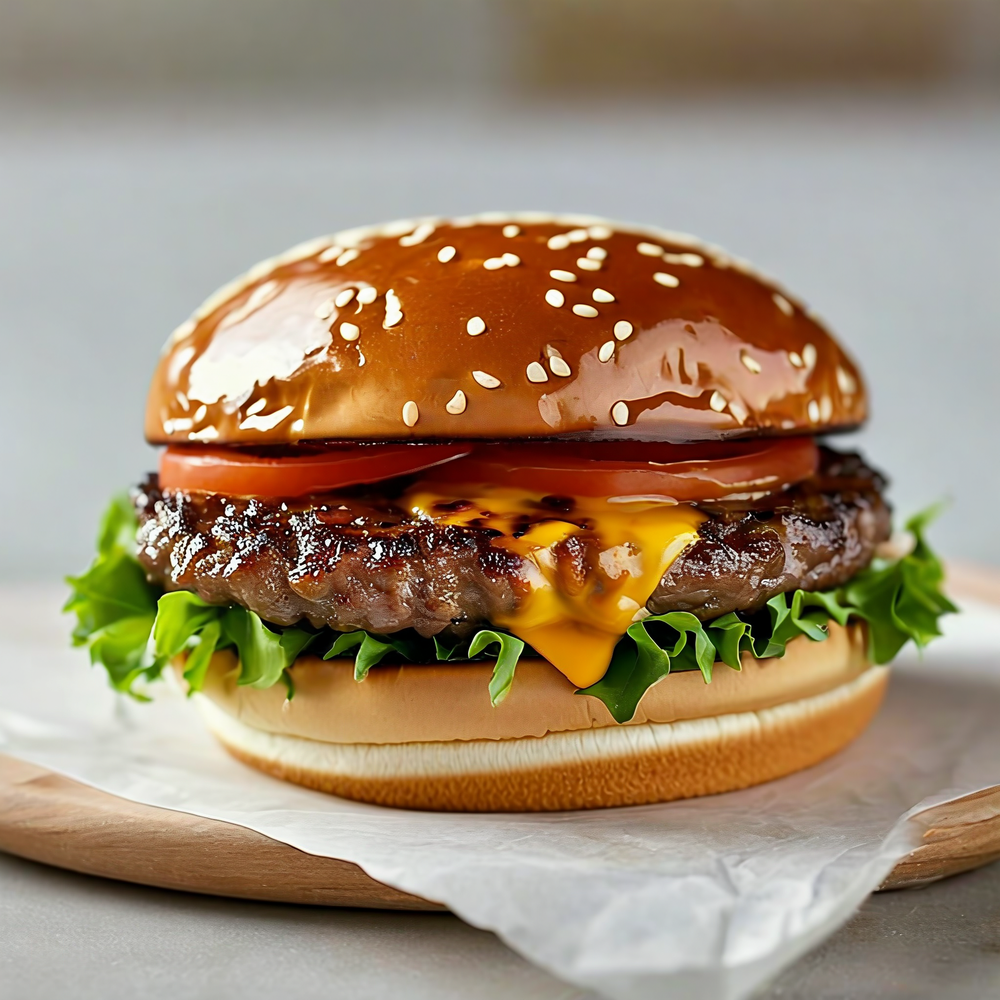

In [29]:
# sample image
img_bytes = get_image_bytes_from_file(file_path=SAMPLE_IMAGE_PATH, format=SAMPLE_IMAGE_FORMAT)
display_image_bytes(img_bytes)

# (Optional) if you have any information about the image, fill in this field.
photo_text = ""

## 1. Image-to-Text (Nova Lite)

In [30]:
PROMPT = f"""You are a copywriter who looks at an image and creates ideas to expand that image.
Refer to the given image and image description to write both the menu name and an image description in one sentence in English.

## Image Description

{photo_text}

## Output Format

Please provide your description in the following format, without any additional explanation:
{{
    "menu_name": "Name of the dish based on the image",
    "prompt": "A one-sentence visual description of the food items included in the image"
}}
"""

res = bedrock_llm.converse_output(text=PROMPT, image=img_bytes, format=SAMPLE_IMAGE_FORMAT)
j = json.loads(res)
menu_name = j.get('menu_name', '')
prompt = j.get('prompt', '')

print(menu_name)
print(prompt)

Classic Cheeseburger
A close-up of a classic cheeseburger with a sesame seed bun, melted cheese, fresh lettuce, and a juicy beef patty topped with a slice of tomato.


## 2. Text-to-Image (Nova Canvas)


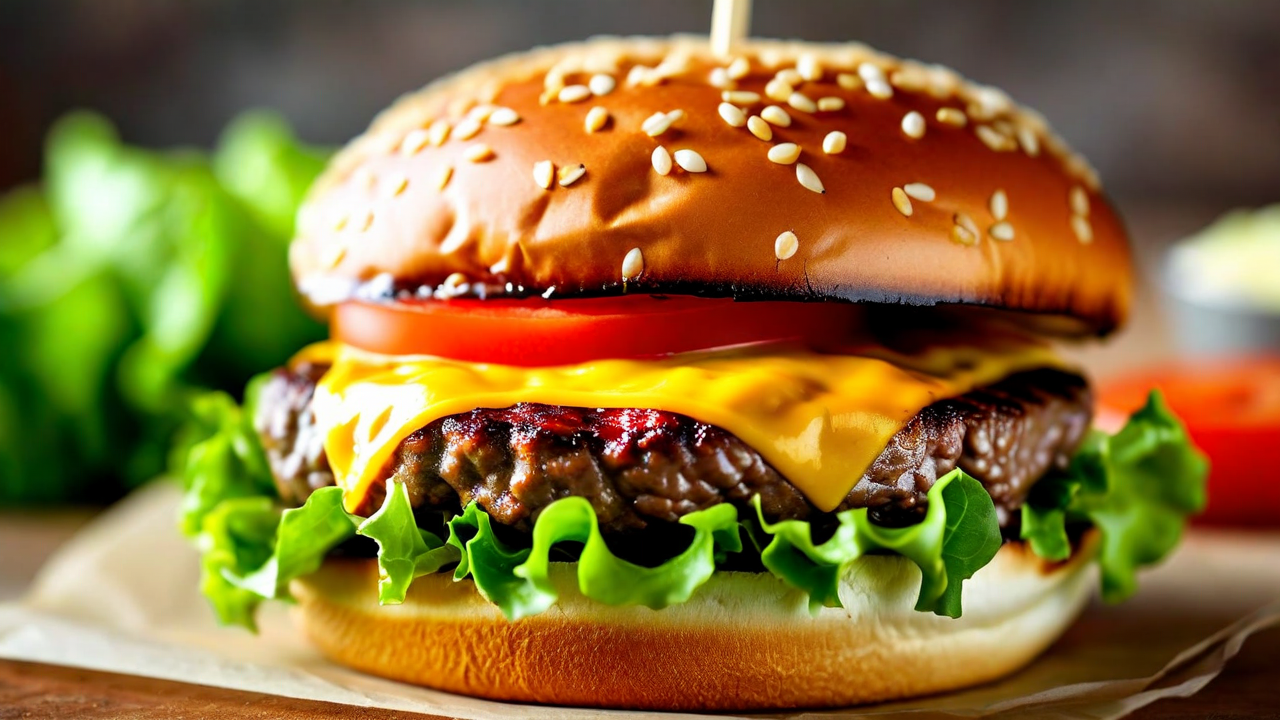

In [31]:
width, height = NovaImageSize.SIZE_1280x720.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

body = image_params.text_to_image(text=prompt)
img = bedrock_image.generate_image(body)
display_image(img)

## 3. Image-to-Image (Nova Canvas)


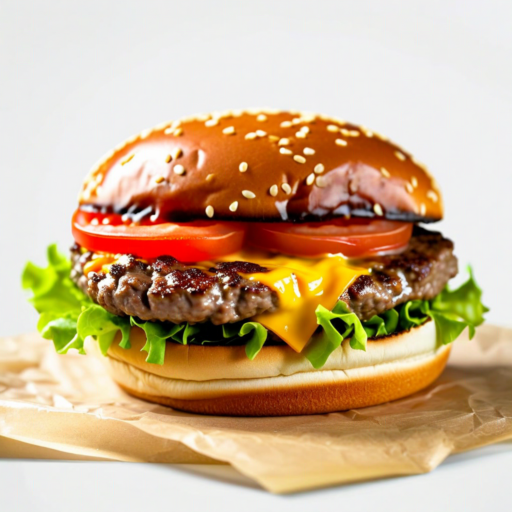

In [32]:
width, height = NovaImageSize.SIZE_512x512.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

body = image_params.text_to_image(
    text=prompt,
    condition_image=bytes_to_base64(img_bytes),
    control_mode=ControlMode.CANNY_EDGE,
    control_strength=0.7,
)
img = bedrock_image.generate_image(body)
display_image(img)

## 4. Generate image prompts to create new content (Nova Lite)

In [13]:
PROMPT = f"""You are a culinary expert and a creative image prompt generator.

## Food

{menu_name}

## Instruction

1. Analyze the provided dish name and image to understand the appearance and characteristics of the food.
2. Describe how to prepare the dish in four sequential steps, ensuring the final result resembles the provided image:
 - Harvesting the main ingredients
 - Preparing the ingredients
 - Cooking process
 - Plating the dish
3. For each step, write a clear and detailed prompt for image generation.
4. Maintain a consistent style across all prompts.

## Output format

Please provide your description in the following format, without any additional explanation:
[
    "prompt1",
    "prompt2",
    "prompt3",
    "prompt4"
]
"""

res = bedrock_llm.converse_output(text=PROMPT)
prompts = json.loads(res)
print(prompts)

['A close-up of fresh, juicy beef patties being carefully selected from a tray, ready for grilling. The beef is marbled and looks tender.', "A close-up of a chef's hands slicing a fresh tomato, cutting a crisp lettuce leaf, and picking up a slice of cheese, all ingredients for a classic cheeseburger.", 'A close-up of a sizzling beef patty on a grill, with smoke rising and grill marks forming. The patty is being flipped to ensure even cooking.', 'A close-up of a perfectly assembled cheeseburger on a white plate. The burger has a golden-brown patty, melted cheese, fresh tomato, crisp lettuce, and a sesame seed bun, garnished with a sprig of fresh parsley.']


## 5. Generate new image contents (Nova Canvas)

A close-up of fresh, juicy beef patties being carefully selected from a tray, ready for grilling. The beef is marbled and looks tender.



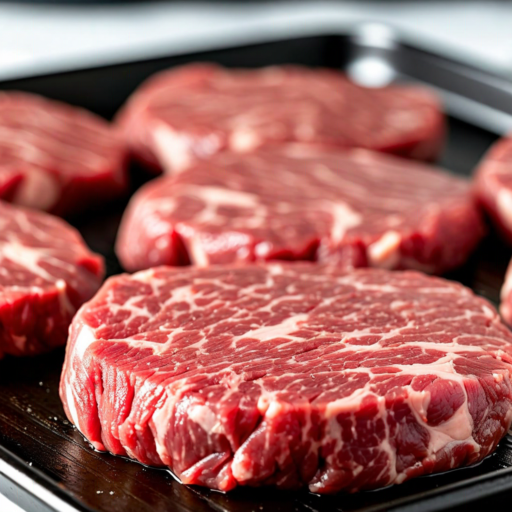

A close-up of a chef's hands slicing a fresh tomato, cutting a crisp lettuce leaf, and picking up a slice of cheese, all ingredients for a classic cheeseburger.



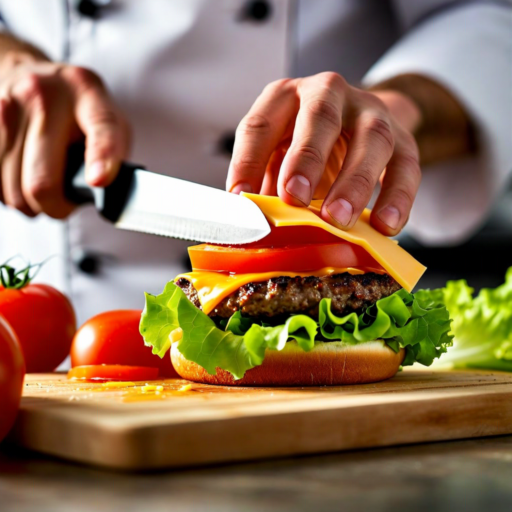

A close-up of a sizzling beef patty on a grill, with smoke rising and grill marks forming. The patty is being flipped to ensure even cooking.



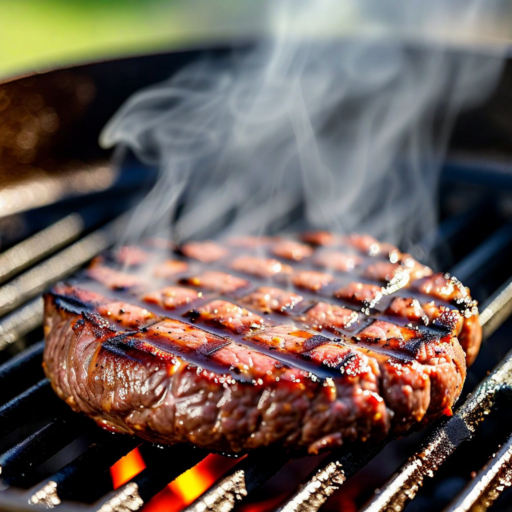

A close-up of a perfectly assembled cheeseburger on a white plate. The burger has a golden-brown patty, melted cheese, fresh tomato, crisp lettuce, and a sesame seed bun, garnished with a sprig of fresh parsley.



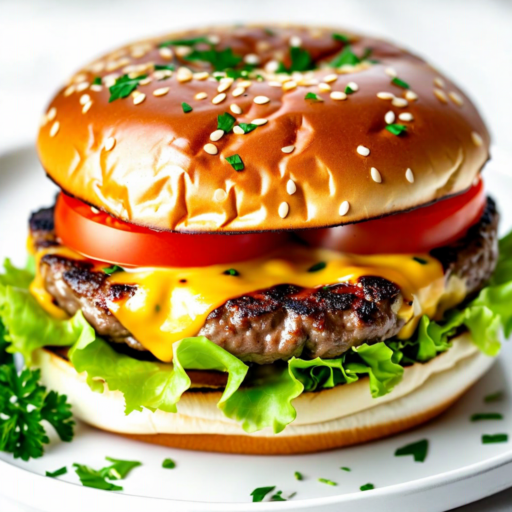

In [14]:
width, height = NovaImageSize.SIZE_512x512.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
)

for prompt in prompts:
    print(prompt)
    body = image_params.text_to_image(text=prompt)
    img = bedrock_image.generate_image(body)
    display_image(img)